In [1]:
%load_ext autoreload
%autoreload 2

import ipywidgets as widgets
import numpy as np
import os
import pandas as pd
import seaborn as sns

from benchmarks import gsa_svm_fitness
from src.entities import GSA

from IPython.display import display
from matplotlib import pyplot as plt
from scipy import stats as st
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from typing import Mapping, Tuple, Union
from ucimlrepo import fetch_ucirepo

In [2]:
uci_datasets = ["Breast Cancer Wisconsin (Diagnostic)",
                "Spambase",
                "Mushroom"]

widget_opt = widgets.Dropdown(options=uci_datasets,
                              description='Dataset: ')

display(widget_opt)

Dropdown(description='Dataset: ', options=('Breast Cancer Wisconsin (Diagnostic)', 'Spambase', 'Mushroom'), va…

In [35]:
def fetch_uci_dataset(dataset_name: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Fetch UCI dataset
    """
    def fetch_categorical_dataset(_id: int) -> Tuple[pd.DataFrame, pd.Series]:
        data = fetch_ucirepo(id=_id)
        X = data.data.features
        y = data.data.targets
        encoder = LabelEncoder()
        for col in X.columns:
            X.loc[:, col] = encoder.fit_transform(X[col])
        return X, y

    if dataset_name == "Breast Cancer Wisconsin (Diagnostic)":
        data = fetch_ucirepo(id=15)
        X = data.data.features
        y = data.data.targets
        X = X.fillna(value=0)
    elif dataset_name == "Spambase":
        X, y = fetch_categorical_dataset(_id=94)
    elif dataset_name == "Mushroom":
        X, y = fetch_categorical_dataset(_id=73)
    
    return X, y

X, y = fetch_uci_dataset(widget_opt.value)

# Name of selected dataset and summary (number of instances, features, etc.)
print(f"Dataset: {widget_opt.value}")
print(f"Instances: {X.shape[0]}")
print(f"Features: {X.shape[1]}")

Dataset: Spambase
Instances: 4601
Features: 57


In [36]:
y.value_counts()

Class
0        2788
1        1813
Name: count, dtype: int64

In [12]:
# WARNING!! GLOBAL VARIABLES
wa = 0.0
wf = 0.0

# IMPORTANT!! MUTABLE GLOBAL VARIABLE
conf_matrix_dict = {"TP": 0, "FP": 0, "TN": 0, "FN": 0}

class UCI:
    """
    Class to handle UCI datasets
    
    Args:
        X (pd.DataFrame): Features
        y (pd.Series): Target
    """
    def __init__(self,
                 X: pd.DataFrame,
                 y: pd.Series,
                 boundaries: Mapping[str, Tuple[Tuple[float, float], ...]],
                 seed: int=5
                 ) -> None:
        """
        Constructor
        
        Args:
            X (pd.DataFrame): Features
            y (pd.Series): Target
            boundaries (Mapping[str, Tuple[Tuple[float, float], ...]): Boundaries for the optimization problem
            seed (int, optional): Random seed. Defaults to 5.
        """
        self.X = X
        self.y = y
        self.boundaries = boundaries

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(self.X)
        
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    
    def get_fitness(self,
                    solution: Mapping[str, np.ndarray],
                    data: Union[None, Tuple[np.ndarray, np.ndarray]] = None,
                    show_confusion_matrix: bool=False
                    ) -> Tuple[float, float]:
        """
        Get fitness of a solution
        
        Args:
            solution (Mapping[str, np.ndarray]): Solution to evaluate
            data (Union[None, Tuple[np.ndarray, np.ndarray]], optional): Data to evaluate the solution. Defaults to None.
        
        Returns:
            Tuple[float, float]: Fitness and accuracy of the solution    
        """
        if data is None:
            X_scaled = self.X_train
            y_data = self.y_train
        else:
            X_scaled, y_data = data
            
        gamma, C = solution['real']
        gamma /= 1_000
        C /= 1_000
        X_scaled_filtered = X_scaled[:, solution['discrete'].astype(int) == 1]
        svc_model = SVC(gamma=gamma, C=C, kernel="rbf", verbose=False)
        svc_model.fit(X_scaled_filtered, np.ravel(y_data))
        y_predict = svc_model.predict(X_scaled_filtered)
        conf_matrix = confusion_matrix(y_data, y_predict)
        if show_confusion_matrix:
            # Update global conf_matrix_dict
            conf_matrix_dict["TP"] = conf_matrix[0, 0]
            conf_matrix_dict["FP"] = conf_matrix[0, 1]
            conf_matrix_dict["TN"] = conf_matrix[1, 1]
            conf_matrix_dict["FN"] = conf_matrix[1, 0]
            print(conf_matrix)
        accuracy = accuracy_score(y_data, y_predict) * 100
        
        return gsa_svm_fitness(accuracy=accuracy, solution=solution, wa=wa, wf=wf)

    def is_feasible(self, solution: Mapping[str, np.ndarray]) -> bool:
        """
        Check if a solution is feasible

        Args:
            solution (Mapping[str, np.ndarray]): Solution to evaluate

        Returns:
            bool: True if the solution is feasible, False otherwise
        """
        real_values = solution['real']
        discrete_values = solution['discrete']

        for i, (min_val, max_val) in enumerate(self.boundaries['real']):
            if real_values[i] < min_val or real_values[i] > max_val:
                return False

        for i, (min_val, max_val) in enumerate(self.boundaries['discrete']):
            if discrete_values[i] < min_val or discrete_values[i] > max_val:
                return False
        
        if sum(discrete_values) == 0:
            return False
        
        return True

boundaries = {'real': [(1, 100_000), (1, 100_000)], 'discrete': [(0, 1) for _ in range(len(X.columns))]}
uci_data = UCI(X, y, boundaries)

In [20]:
from random import randint, seed 

def run_gsa(chaotic_constant: bool=False,
            repair_solution: bool=False,
            runs: int=10,
            population_size: int=5,
            iterations: int=20
            ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    global_train_hist = pd.DataFrame()
    global_test_hist = pd.DataFrame(columns=["run", "accuracy", "fitness", "TP", "FP", "TN", "FN"])
    
    for k in range(runs):
        gsa_seed = randint(0, 1000)
        uci_data = UCI(X, y, boundaries)
        
        gsa_algo = GSA(objective_function = uci_data.get_fitness,
                       is_feasible=uci_data.is_feasible,
                       r_dim=2,
                       d_dim=len(X.columns),
                       boundaries=uci_data.boundaries)
        
        gsa_algo.set_seed(seed=gsa_seed)
        training_history = gsa_algo.optimize(population_size=population_size,
                                             iters=iterations,
                                             chaotic_constant=chaotic_constant,
                                             repair_solution=repair_solution)
        
        training_history.insert(0, "run", k)
        global_train_hist = pd.concat([global_train_hist, training_history], axis=0)
        
        print(gsa_algo.solution_history[-1])
        fitness, accuracy = uci_data.get_fitness(solution=gsa_algo.solution_history[-1],
                                            data=(uci_data.X_test, uci_data.y_test),
                                            show_confusion_matrix=True)
        
        global_test_hist.loc[len(global_test_hist)] = [k, accuracy, fitness, conf_matrix_dict["TP"], conf_matrix_dict["FP"], conf_matrix_dict["TN"], conf_matrix_dict["FN"]]
        
        print("Test accuracy: ", accuracy, " - Fitness: ", fitness)
    
    return global_train_hist, global_test_hist

In [27]:
seed(22)

wa = 0.8
wf = 0.2
train_df = pd.DataFrame()
test_df = pd.DataFrame()
for chaotic_constant in [True, False]:
    print(f"Running GSA with chaotic constant: ", chaotic_constant)
    tr_df, tt_df = run_gsa(chaotic_constant=chaotic_constant,
                           runs=10,
                           population_size=5,
                           iterations=20)
    
    tr_df["chaotic_constant"] = chaotic_constant
    tt_df["chaotic_constant"] = chaotic_constant
    train_df = pd.concat([train_df, tr_df], axis=0)
    test_df = pd.concat([test_df, tt_df], axis=0)

Running GSA with chaotic constant:  True
GSA is optimizing  "get_fitness"
['At iteration 1 the best fitness is 90.39554760484995']
['At iteration 2 the best fitness is 92.40707612800637']
['At iteration 3 the best fitness is 92.40707612800637']
['At iteration 4 the best fitness is 92.40707612800637']
['At iteration 5 the best fitness is 92.40707612800637']
['At iteration 6 the best fitness is 92.40707612800637']
['At iteration 7 the best fitness is 92.40707612800637']
['At iteration 8 the best fitness is 92.40707612800637']
['At iteration 9 the best fitness is 92.40707612800637']
['At iteration 10 the best fitness is 92.40707612800637']
['At iteration 11 the best fitness is 92.40707612800637']
['At iteration 12 the best fitness is 92.40707612800637']
['At iteration 13 the best fitness is 92.7608825283244']
['At iteration 14 the best fitness is 92.7608825283244']
['At iteration 15 the best fitness is 92.7608825283244']
['At iteration 16 the best fitness is 92.7608825283244']
['At iterat

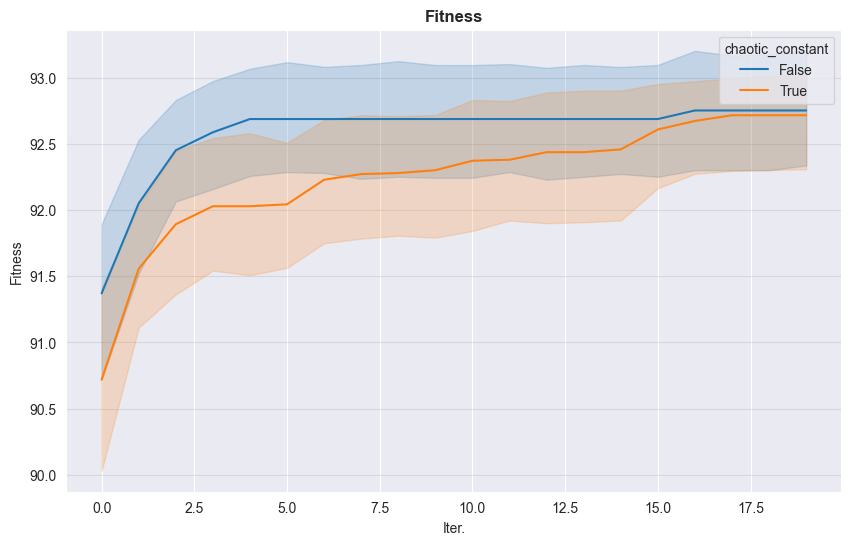

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Fitness", fontweight='bold')

# ax.set_ylim(min(global_train_hist["Fitness"]), max(global_train_hist["Fitness"]))
    
sns.lineplot(ax=ax,
             data=train_df,
             x="Iteration",
             y="Fitness",
             hue="chaotic_constant",
             legend=True)

ax.grid(axis='y', color='#A9A9A9', alpha=0.3, zorder=1)

ax.set_xlabel("Iter.")
ax.set_ylabel("Fitness")

plt.show()
# fig.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)

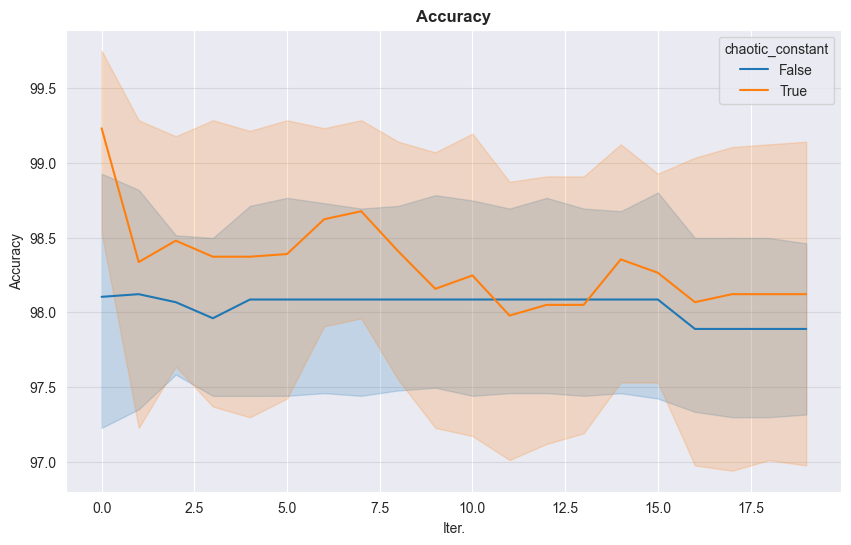

In [29]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Accuracy", fontweight='bold')

# ax.set_ylim(min(global_train_hist["Fitness"]), max(global_train_hist["Fitness"]))
    
sns.lineplot(ax=ax,
             data=train_df,
             x="Iteration",
             y="Accuracy",
             hue="chaotic_constant",
             legend=True)

ax.grid(axis='y', color='#A9A9A9', alpha=0.3, zorder=1)

ax.set_xlabel("Iter.")
ax.set_ylabel("Accuracy")

plt.show()
# fig.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)

In [30]:
# T-test results (with and without Chaotic constant)

# accuracy history in train_df between chaotic_constant=True and chaotic_constant=False
chaotic_constant_true = train_df[train_df["chaotic_constant"] == True]["Accuracy"]
chaotic_constant_false = train_df[train_df["chaotic_constant"] == False]["Accuracy"]

st.ttest_ind(chaotic_constant_true, chaotic_constant_false)

TtestResult(statistic=2.1733431629644375, pvalue=0.030343551192465856, df=398.0)

# Compare accuracy weight (wa) and fitness weight (wf) effect on the number of features and convergence of accuracy and fitness

In [31]:
seed(22)

train_df = pd.DataFrame()
test_df = pd.DataFrame()

for wa in np.arange(0.1, 1.0, 0.1):
    wf = 1 - wa
    print(f"Running GSA with wa = {wa}, wf = {wf}")
    tr_df, tt_df = run_gsa(uci_data,
                           runs=10,
                           population_size=5,
                           iterations=20)
    
    tr_df["wa"] = wa
    tt_df["wa"] = wf
    train_df = pd.concat([train_df, tr_df], axis=0)
    test_df = pd.concat([test_df, tt_df], axis=0)

Running GSA with wa = 0.1, wf = 0.9
GSA is optimizing  "get_fitness"
['At iteration 1 the best fitness is 59.94633273703041']
['At iteration 2 the best fitness is 88.98032200357781']
['At iteration 3 the best fitness is 88.98032200357781']
['At iteration 4 the best fitness is 88.98032200357781']
['At iteration 5 the best fitness is 88.98032200357781']
['At iteration 6 the best fitness is 88.98032200357781']
['At iteration 7 the best fitness is 88.98032200357781']
['At iteration 8 the best fitness is 88.98032200357781']
['At iteration 9 the best fitness is 88.99821109123435']
['At iteration 10 the best fitness is 88.99821109123435']
['At iteration 11 the best fitness is 88.99821109123435']
['At iteration 12 the best fitness is 89.2128801431127']
['At iteration 13 the best fitness is 89.2128801431127']
['At iteration 14 the best fitness is 89.2128801431127']
['At iteration 15 the best fitness is 89.2128801431127']
['At iteration 16 the best fitness is 89.2128801431127']
['At iteration 17

## wa-wf effect on the number of features

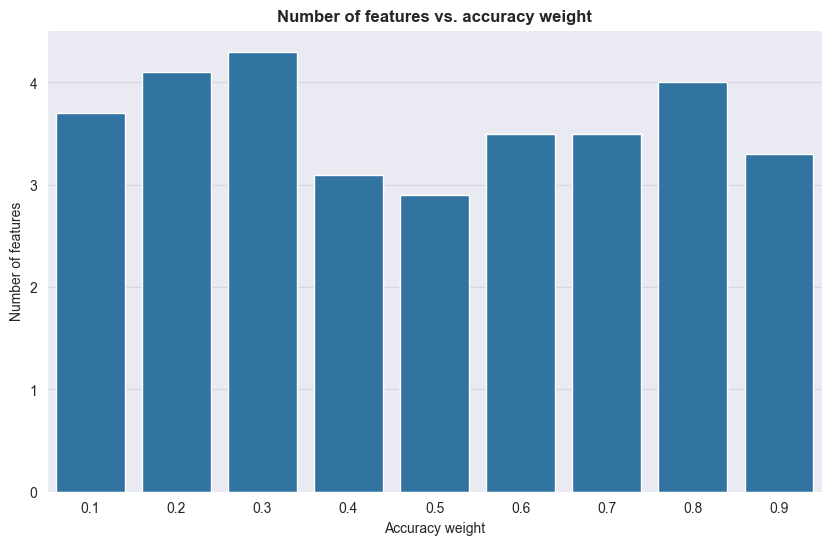

In [32]:
# Get last solution from discrete best solution history
train_df['NumFeatures'] = train_df['Discrete'].apply(lambda x: np.sum(x[-1]))

# Group by 'wa' and get mean of number of features
result_df = train_df.groupby('wa')['NumFeatures'].mean().reset_index()

# Sns bar plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Number of features vs. accuracy weight", fontweight='bold')

sns.barplot(ax=ax,
            data=result_df,
            x='wa',
            y='NumFeatures')

ax.grid(axis='y', color='#A9A9A9', alpha=0.3, zorder=1)

ax.set_xticks(range(len(result_df)))
ax.set_xticklabels(np.round(result_df["wa"], 1))

ax.set_xlabel("Accuracy weight")
ax.set_ylabel("Number of features")

plt.show()
# fig.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)

## Fitness convergence

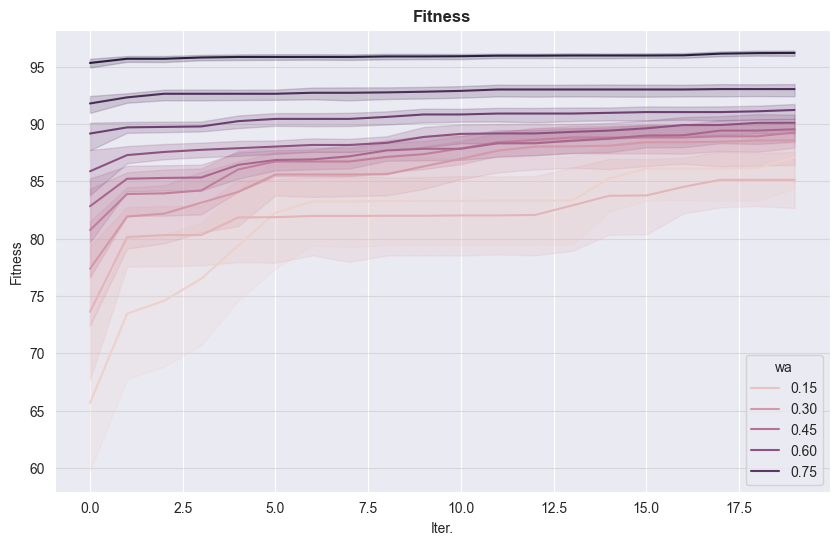

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Fitness", fontweight='bold')

# ax.set_ylim(min(global_train_hist["Fitness"]), max(global_train_hist["Fitness"]))
    
sns.lineplot(ax=ax,
             data=train_df,
             x="Iteration",
             y="Fitness",
             hue="wa",
             legend=True)

ax.grid(axis='y', color='#A9A9A9', alpha=0.3, zorder=1)

ax.set_xlabel("Iter.")
ax.set_ylabel("Fitness")

plt.show()
# fig.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)

## Accuracy convergence

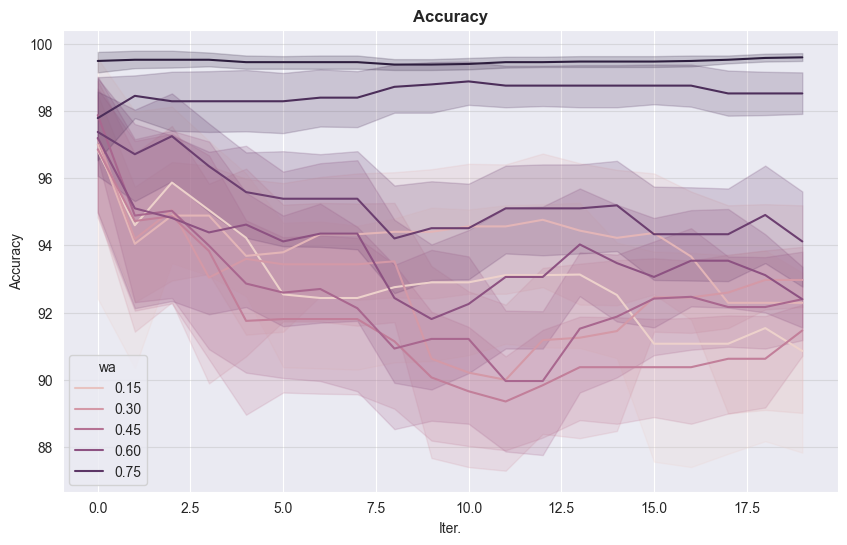

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Accuracy", fontweight='bold')

# ax.set_ylim(min(global_train_hist["Fitness"]), max(global_train_hist["Fitness"]))
    
sns.lineplot(ax=ax,
             data=train_df,
             x="Iteration",
             y="Accuracy",
             hue="wa",
             legend=True)

ax.grid(axis='y', color='#A9A9A9', alpha=0.3, zorder=1)

ax.set_xlabel("Iter.")
ax.set_ylabel("Accuracy")

plt.show()
# fig.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
mean_accuracy = np.round(np.mean(gsa_history_dict["accuracy_history"]), 4)
std_accuracy = np.round(np.std(gsa_history_dict["accuracy_history"]), 4)

print(f"Mean accuracy: {mean_accuracy} +/- {std_accuracy}")

mean_gamma = np.round(np.mean(gsa_history_dict["gamma_history"]), 4)
std_gamma = np.round(np.std(gsa_history_dict["gamma_history"]), 4)

print(f"Mean gamma: {mean_gamma} +/- {std_gamma}")

mean_c = np.round(np.mean(gsa_history_dict["c_history"]), 4)
std_c = np.round(np.std(gsa_history_dict["c_history"]), 4)

print(f"Mean C: {mean_c} +/- {std_c}")

mean_n_features = np.rint(np.mean(gsa_history_dict["n_features_history"])).astype(int)
std_n_features = np.rint(np.std(gsa_history_dict["n_features_history"])).astype(int)

print(f"Mean n_features: {mean_n_features} +/- {std_n_features}")

mean_execution_time = np.round(np.mean(gsa_history_dict["execution_time_history"]), 4)
std_execution_time = np.round(np.std(gsa_history_dict["execution_time_history"]), 4)

print(f"Mean execution time: {mean_execution_time} +/- {std_execution_time}")

mean_TP = np.rint(np.mean(gsa_history_dict["TP_history"])).astype(int)
std_TP = np.rint(np.std(gsa_history_dict["TP_history"])).astype(int)
mean_FP = np.rint(np.mean(gsa_history_dict["FP_history"])).astype(int)
std_FP = np.rint(np.std(gsa_history_dict["FP_history"])).astype(int)
mean_TN = np.rint(np.mean(gsa_history_dict["TN_history"])).astype(int)
std_TN = np.rint(np.std(gsa_history_dict["TN_history"])).astype(int)
mean_FN = np.rint(np.mean(gsa_history_dict["FN_history"])).astype(int)
std_FN = np.rint(np.std(gsa_history_dict["FN_history"])).astype(int)

In [ ]:
import datetime

save_path = "../data/output"
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
date = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

results = pd.DataFrame({"date": [date],
                        "dataset_name": [widget_opt.value],
                        "r_runs": [runs],
                        "n_pop": [population_size],
                        "n_iters": [iterations],
                        "chaotic_constant": [chaotic_constant],
                        "repair_solution": [repair_solution],
                        "execution_time": [mean_execution_time],
                        "execution_time_std": [std_execution_time],
                        "wa": [wa],
                        "wf": [wf],
                        "mean_accuracy": [mean_accuracy],
                        "std_accuracy": [std_accuracy],
                        "mean_gamma": [mean_gamma],
                        "std_gamma": [std_gamma],
                        "mean_c": [mean_c],
                        "std_c": [std_c],
                        "mean_n_features": [mean_n_features],
                        "std_n_features": [std_n_features],
                        "TP": [mean_TP],
                        "TP_std": [std_TP],
                        "FP": [mean_FP],
                        "FP_std": [std_FP],
                        "TN": [mean_TN],
                        "TN_std": [std_TN],
                        "FN": [mean_FN],
                        "FN_std": [std_FN]})

file = f"{save_path}/gsa_records.csv"
if os.path.exists(file):
    # Load dataframe and append new row
    df = pd.read_csv(file)
    df = pd.concat([df, results], axis=0, ignore_index=True)
    df.to_csv(file, index=False)
else: # Append row to existing file
    results.to_csv(file, index=False)